In [1]:
# uv pip install torch transformers numpy

In [1]:
# PyTorch imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

# Model imports
from model import SmartContractTransformer

# Training imports
from train import SmartContractTrainer

# Optional but useful imports
import numpy as np
from tqdm import tqdm  # for progress bars
import logging 


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/usr/lib/python3.11/runpy.py", line 198, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.11/runpy.py", line 88, in _run_code
    exec(code, run_globals)
  File "/home/m20180848/pytorch_env/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/m20180848/pytorch_env/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/m20180848/pytorch_env

In [2]:
from transformers import AutoTokenizer
import json
import os
import pandas as pd
from typing import Dict, List, Tuple, Any
import re

- Dataset.py script:

In [3]:
print(f"CUDA is available: {torch.cuda.is_available()}")
print(f"Number of GPUs: {torch.cuda.device_count()}")

CUDA is available: True
Number of GPUs: 2


In [4]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

def parse_solidity_to_ast(code: str) -> Dict[str, Any]:
    """
    Parse Solidity code into a simplified AST structure
    """
    def extract_contract_info(code: str) -> Dict[str, Any]:
        # Extract contract name
        contract_match = re.search(r'contract\s+(\w+)', code)
        contract_name = contract_match.group(1) if contract_match else "Unknown"
        
        # Extract functions
        functions = []
        function_pattern = r'function\s+(\w+)\s*\(([^)]*)\)\s*(?:public|private|internal|external)?\s*(?:view|pure|payable)?\s*(?:returns\s*\(([^)]*)\))?\s*{'
        for match in re.finditer(function_pattern, code):
            func_name = match.group(1)
            params = match.group(2).split(',') if match.group(2) else []
            returns = match.group(3).split(',') if match.group(3) else []
            
            functions.append({
                'name': func_name,
                'parameters': [p.strip() for p in params],
                'returns': [r.strip() for r in returns]
            })
        
        # Extract state variables
        variables = []
        var_pattern = r'(?:uint|address|string|bool|mapping)\s+(?:\w+)\s+(\w+)'
        for match in re.finditer(var_pattern, code):
            variables.append(match.group(1))
        
        return {
            'type': 'Contract',
            'name': contract_name,
            'functions': functions,
            'variables': variables
        }
    
    try:
        # Clean the code
        code = re.sub(r'//.*?\n|/\*.*?\*/', '', code)  # Remove comments
        code = re.sub(r'\s+', ' ', code)  # Normalize whitespace
        
        # Parse the code
        ast = extract_contract_info(code)
        return ast
    except Exception as e:
        print(f"Error parsing code: {str(e)}")
        return None

def prepare_code2vec_input(ast: Dict[str, Any]) -> List[str]:
    """
    Convert AST to codeBert input format
    """
    paths = []
    
    def extract_paths(node: Dict[str, Any], current_path: List[str] = None):
        if current_path is None:
            current_path = []
            
        # Add current node to path
        if 'name' in node:
            current_path.append(node['name'])
            
        # Process functions
        if 'functions' in node:
            for func in node['functions']:
                func_path = current_path + [func['name']]
                paths.append(' '.join(func_path))
                
                # Add parameter paths
                for param in func['parameters']:
                    param_path = func_path + [param]
                    paths.append(' '.join(param_path))
                
                # Add return paths
                for ret in func['returns']:
                    ret_path = func_path + [ret]
                    paths.append(' '.join(ret_path))
        
        # Process variables
        if 'variables' in node:
            for var in node['variables']:
                var_path = current_path + [var]
                paths.append(' '.join(var_path))
    
    extract_paths(ast)
    return paths

class SmartContractVulnerabilityDataset(Dataset):
    def __init__(
        self,
        data_path: str,
        tokenizer: AutoTokenizer,
        max_length: int = 1024,
        split: str = "train",
        vulnerability_types: List[str] = None
    ):
        """
        Args:
            data_path: Path to the CSV file containing the dataset
            tokenizer: Tokenizer for encoding the source code
            max_length: Maximum sequence length
            split: "train" or "val" to specify which split to load
            vulnerability_types: List of vulnerability types to consider
        """
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.split = split
        self.vulnerability_types = vulnerability_types or [
            'ARTHM', 'DOS', 'LE', 'RENT', 'TimeM', 'TimeO', 'Tx-Origin', 'UE'
        ]
        
        # Load the dataset
        self.data = self._load_dataset(data_path)
        
    def _load_dataset(self, data_path: str) -> List[Dict]:
        """Load and preprocess the dataset from CSV"""
        dataset = []
        
        # Read the CSV file
        df = pd.read_csv(data_path)
        
        # Split into train/val if needed
        if self.split == "train":
            df = df.sample(frac=0.8, random_state=42)
        else:
            df = df.sample(frac=0.2, random_state=42)
        
        # Process each contract
        for _, row in df.iterrows():
            try:
                source_code = row['source_code']
                contract_name = row['contract_name']
                
                # Parse AST and get paths
                ast = parse_solidity_to_ast(source_code)
                ast_paths = prepare_code2vec_input(ast) if ast else []
                ast_path_text = ' '.join(ast_paths)
                
                # Split source code into lines
                lines = source_code.split('\n')
                
                # Create token-to-line mapping
                token_to_line = []
                current_line = 0
                
                # Tokenize each line separately to maintain mapping
                for line in lines:
                    line_tokens = self.tokenizer.encode(line, add_special_tokens=False)
                    token_to_line.extend([current_line] * len(line_tokens))
                    current_line += 1
                
                # Add special tokens
                token_to_line = [0] + token_to_line + [0]  # [CLS] and [SEP] tokens
                
                # Truncate if too long
                if len(token_to_line) > self.max_length:
                    token_to_line = token_to_line[:self.max_length]
                
                # Pad if too short
                if len(token_to_line) < self.max_length:
                    token_to_line.extend([0] * (self.max_length - len(token_to_line)))
                
                # Create multi-label line labels for each vulnerability type
                line_labels = self._create_multi_label_line_labels(source_code, row)
                
                # Create contract-level vulnerability labels
                contract_labels = self._create_contract_vulnerability_labels(row)
                
                # Tokenize the source code
                encoding = self.tokenizer(
                    source_code,
                    max_length=self.max_length,
                    padding='max_length',
                    truncation=True,
                    return_tensors='pt'
                )
                
                # Tokenize AST paths
                ast_encoding = self.tokenizer(
                    ast_path_text,
                    max_length=self.max_length,
                    padding='max_length',
                    truncation=True,
                    return_tensors='pt'
                )
                
                # Convert line labels to tensor and ensure consistent shape
                vuln_tensor = torch.zeros((len(self.vulnerability_types), self.max_length), dtype=torch.long)
                for i, labels in enumerate(line_labels):
                    if len(labels) > self.max_length:
                        labels = labels[:self.max_length]
                    vuln_tensor[i, :len(labels)] = torch.tensor(labels, dtype=torch.long)
                
                # Convert contract labels to tensor
                contract_vuln_tensor = torch.tensor(contract_labels, dtype=torch.long)
                
                # Convert token_to_line to tensor
                token_to_line_tensor = torch.tensor(token_to_line, dtype=torch.long)
                
                # Ensure attention masks are boolean
                attention_mask = encoding['attention_mask'].squeeze(0).bool()
                ast_attention_mask = ast_encoding['attention_mask'].squeeze(0).bool()
                
                # Ensure input_ids are the right length
                input_ids = encoding['input_ids'].squeeze(0)
                ast_input_ids = ast_encoding['input_ids'].squeeze(0)
                
                if len(input_ids) > self.max_length:
                    input_ids = input_ids[:self.max_length]
                if len(ast_input_ids) > self.max_length:
                    ast_input_ids = ast_input_ids[:self.max_length]
                
                # Pad if necessary
                if len(input_ids) < self.max_length:
                    input_ids = torch.nn.functional.pad(input_ids, (0, self.max_length - len(input_ids)))
                if len(ast_input_ids) < self.max_length:
                    ast_input_ids = torch.nn.functional.pad(ast_input_ids, (0, self.max_length - len(ast_input_ids)))
                
                dataset.append({
                    'input_ids': input_ids,
                    'attention_mask': attention_mask,
                    'ast_input_ids': ast_input_ids,
                    'ast_attention_mask': ast_attention_mask,
                    'vulnerable_lines': vuln_tensor,
                    'contract_vulnerabilities': contract_vuln_tensor,
                    'token_to_line': token_to_line_tensor,
                    'source_code': source_code,
                    'contract_name': contract_name
                })
            except Exception as e:
                print(f"Error processing contract {contract_name}: {str(e)}")
                continue
        
        return dataset
    
    def _create_contract_vulnerability_labels(self, row: pd.Series) -> List[int]:
        """Create contract-level vulnerability labels"""
        contract_labels = []
        for vuln_type in self.vulnerability_types:
            # Check if contract has this vulnerability type
            vuln_lines = row[f'{vuln_type}_lines']
            if isinstance(vuln_lines, str):
                try:
                    vuln_lines = eval(vuln_lines)
                except:
                    vuln_lines = [vuln_lines]
            
            # Contract is vulnerable if it has any vulnerable lines
            has_vulnerability = len(vuln_lines) > 0
            contract_labels.append(1 if has_vulnerability else 0)
        
        return contract_labels
    
    def _create_multi_label_line_labels(self, source_code: str, row: pd.Series) -> List[List[int]]:
        """Create multi-label line labels for each vulnerability type"""
        total_lines = len(source_code.split('\n'))
        line_labels = {vuln_type: [0] * total_lines for vuln_type in self.vulnerability_types}
        
        # Process each vulnerability type
        for vuln_type in self.vulnerability_types:
            vuln_lines = row[f'{vuln_type}_lines']
            if isinstance(vuln_lines, str):
                try:
                    vuln_lines = eval(vuln_lines)
                except:
                    vuln_lines = [vuln_lines]
            
            # Process each vulnerable line/snippet
            for line_or_snippet in vuln_lines:
                if isinstance(line_or_snippet, int):
                    # If it's a line number, mark that line
                    if 0 <= line_or_snippet < total_lines:
                        line_labels[vuln_type][line_or_snippet] = 1
                else:
                    # If it's a code snippet, find matching lines
                    source_lines = source_code.split('\n')
                    for i, line in enumerate(source_lines):
                        # Clean both the line and snippet for comparison
                        clean_line = re.sub(r'\s+', ' ', line.strip())
                        clean_snippet = re.sub(r'\s+', ' ', str(line_or_snippet).strip())
                        if clean_snippet in clean_line:
                            line_labels[vuln_type][i] = 1
        
        # Convert to list format
        return [line_labels[vuln_type] for vuln_type in self.vulnerability_types]
    
    def __len__(self) -> int:
        return len(self.data)
    
    def __getitem__(self, idx: int) -> Dict:
        return self.data[idx]

def custom_collate_fn(batch):
    """
    Custom collate function to handle variable length inputs
    """
    # Get the maximum length in this batch for each type of tensor
    max_input_len = max(item['input_ids'].size(0) for item in batch)
    
    # Pad all tensors to their respective maximum lengths
    padded_batch = {
        'input_ids': torch.stack([
            torch.nn.functional.pad(item['input_ids'], (0, max_input_len - item['input_ids'].size(0)))
            for item in batch
        ]),
        'attention_mask': torch.stack([
            torch.nn.functional.pad(item['attention_mask'], (0, max_input_len - item['attention_mask'].size(0)))
            for item in batch
        ]),
        'ast_input_ids': torch.stack([item['ast_input_ids'] for item in batch]),
        'ast_attention_mask': torch.stack([item['ast_attention_mask'] for item in batch]),
        'vulnerable_lines': torch.stack([item['vulnerable_lines'] for item in batch]),
        'contract_vulnerabilities': torch.stack([item['contract_vulnerabilities'] for item in batch]),
        'token_to_line': torch.stack([item['token_to_line'] for item in batch]),
        'source_code': [item['source_code'] for item in batch],
        'contract_name': [item['contract_name'] for item in batch]
    }
    
    return padded_batch

def create_dataloaders(
    data_path: str,
    tokenizer: AutoTokenizer,
    batch_size: int = 8,
    max_length: int = 1024,
    num_workers: int = 4,
    vulnerability_types: List[str] = None
) -> Tuple[torch.utils.data.DataLoader, torch.utils.data.DataLoader]:
    """
    Create train and validation dataloaders
    
    Args:
        data_path: Path to the CSV file containing the dataset
        tokenizer: Tokenizer for encoding the source code
        batch_size: Batch size for training
        max_length: Maximum sequence length
        num_workers: Number of workers for data loading
        vulnerability_types: List of vulnerability types to consider
    
    Returns:
        Tuple of (train_dataloader, val_dataloader)
    """
    # Create datasets
    train_dataset = SmartContractVulnerabilityDataset(
        data_path=data_path,
        tokenizer=tokenizer,
        max_length=max_length,
        split="train",
        vulnerability_types=vulnerability_types
    )
    
    val_dataset = SmartContractVulnerabilityDataset(
        data_path=data_path,
        tokenizer=tokenizer,
        max_length=max_length,
        split="val",
        vulnerability_types=vulnerability_types
    )
    
    # Create dataloaders with custom collate function
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        collate_fn=custom_collate_fn
    )
    
    val_dataloader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        collate_fn=custom_collate_fn
    )
    
    return train_dataloader, val_dataloader

In [5]:
from transformers import AutoTokenizer

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")

# Create dataloaders
train_dataloader, val_dataloader = create_dataloaders(
    data_path="contract_sources_with_vulnerabilities_2048_token_size.csv",
    tokenizer=tokenizer,
    batch_size=8,
    max_length=1024,
    vulnerability_types=['ARTHM', 'DOS', 'LE', 'RENT', 'TimeM', 'TimeO', 'Tx-Origin', 'UE']
)

Token indices sequence length is longer than the specified maximum sequence length for this model (1211 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
model = SmartContractTransformer()

trainer = SmartContractTrainer(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    tokenizer=tokenizer,
    learning_rate=0.08,
    weight_decay=0.001,
    max_grad_norm= 1.0
)

# Start training
trainer.train(num_epochs=400, checkpoint_dir='checkpoints_v2_2048_output')


Epoch 1/400


Epoch 0:   2%|▏         | 5/253 [00:04<03:15,  1.27it/s, gen_loss=10.8250, contract_vuln_loss=0.1225, line_vuln_loss=0.1225, lr=0.000020]

In [ ]:
print("Done")

## Re-trainning phase

In [24]:
def load_trained_model(checkpoint_path):
    """
    Load a trained model and discriminator from checkpoint
    """

    device = torch.device('cuda:1')
    
    # Initialize model and discriminator
    model = SmartContractTransformer()
    discriminator = Discriminator()
    
    model = model.to(device)
    discriminator = discriminator.to(device)
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Load model and discriminator states
    model.load_state_dict(checkpoint['model_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])

    if 'optimizer_state_dict' in checkpoint:
        for param_group in checkpoint['optimizer_state_dict']['param_groups']:
            param_group['lr'] = 0.02
    if 'discriminator_optimizer_state_dict' in checkpoint:
        for param_group in checkpoint['discriminator_optimizer_state_dict']['param_groups']:
            param_group['lr'] = 0.02
    
    print(f"Loaded model from epoch {checkpoint['epoch']}")
    print(f"Validation loss: {checkpoint['val_loss']:.4f}")
    print(f"Reset learning rate to 0.02")
    
    return model, discriminator, checkpoint

# Load pre-trained model
checkpoint_path = 'checkpoints_v1_512_output/best_model_epoch_40.pt'  
model, discriminator, checkpoint = load_trained_model(checkpoint_path)

Loaded model from epoch 40
Validation loss: 4.5804
Reset learning rate to 0.002


In [27]:
trainer = SmartContractTrainer(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    learning_rate=0.02,
    weight_decay=0.002,
    max_grad_norm=1.0,
    gpu_id=1
)

# Load optimizer states if available
if 'optimizer_state_dict' in checkpoint:
    trainer.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
if 'discriminator_optimizer_state_dict' in checkpoint:
    trainer.discriminator_optimizer.load_state_dict(checkpoint['discriminator_optimizer_state_dict'])

# Start training
trainer.train(num_epochs=200, checkpoint_dir='checkpoints_v1_512_retrain/') 

/home/m20180848/pytorch_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "



Epoch 1/200


Training: 100%|██████████| 88/88 [05:39<00:00,  3.85s/it, gen_loss=3.78, vuln_loss=0.377, synth_loss=0.766, diversity_loss=-0, d_penalty=0, g_penalty=0, is_synthetic=0]         


Train Loss: 0.0873
Val Loss: 4.6308
Vulnerability Loss: 9.4490
Synthetic Loss: 23.9306
Learning Rate: 0.020000
Saved checkpoint to checkpoints_v1_512_retrain/best_model_epoch_1.pt

Epoch 2/200


Training: 100%|██████████| 88/88 [05:47<00:00,  3.95s/it, gen_loss=4.87, vuln_loss=0.378, synth_loss=0.317, diversity_loss=-0, d_penalty=0, g_penalty=0, is_synthetic=1]


Train Loss: 0.1122
Val Loss: 4.6044
Vulnerability Loss: 0.3398
Synthetic Loss: 0.5832
Learning Rate: 0.020000
Saved checkpoint to checkpoints_v1_512_retrain/best_model_epoch_2.pt

Epoch 3/200


Training: 100%|██████████| 88/88 [05:29<00:00,  3.74s/it, gen_loss=4.2, vuln_loss=0.246, synth_loss=0.84, diversity_loss=-0, d_penalty=0, g_penalty=0, is_synthetic=0]  


Train Loss: 0.0973
Val Loss: 4.6069
Vulnerability Loss: 0.3393
Synthetic Loss: 0.5637
Learning Rate: 0.020000

Epoch 4/200


Training: 100%|██████████| 88/88 [05:19<00:00,  3.64s/it, gen_loss=3.8, vuln_loss=0.247, synth_loss=0.258, diversity_loss=-0, d_penalty=0, g_penalty=0, is_synthetic=1] 


Train Loss: 0.0883
Val Loss: 4.6367
Vulnerability Loss: 0.3413
Synthetic Loss: 0.5390
Learning Rate: 0.020000

Epoch 5/200


Training:   6%|▌         | 5/88 [00:22<06:18,  4.57s/it, gen_loss=4.96, vuln_loss=0.444, synth_loss=0.864, diversity_loss=-0, d_penalty=0, g_penalty=0, is_synthetic=0]


KeyboardInterrupt: 

In [ ]:
print("Done")

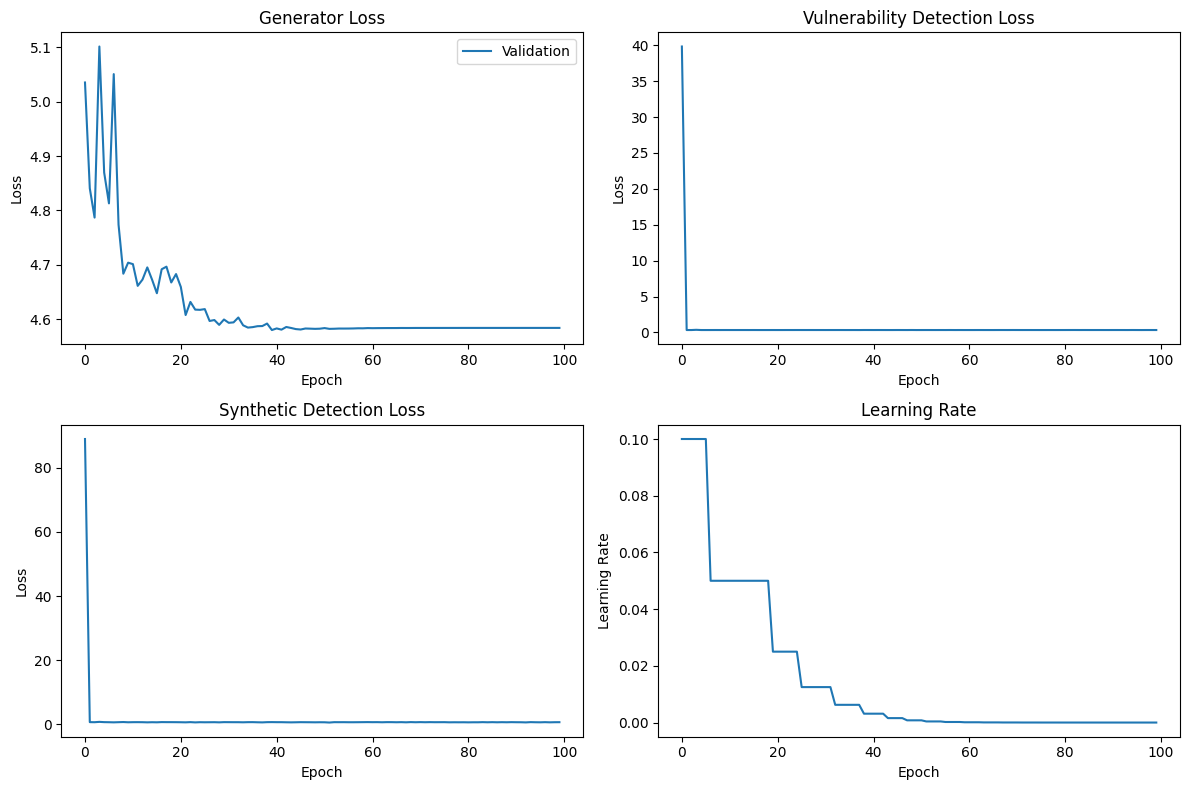

In [15]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(12, 8))

# Plot generator loss
plt.subplot(2, 2, 1)
#plt.plot(trainer.training_history['train_loss'], label='Train')
plt.plot(trainer.training_history['val_loss'], label='Validation')
plt.title('Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot vulnerability loss
plt.subplot(2, 2, 2)
plt.plot(trainer.training_history['vulnerability_loss'])
plt.title('Vulnerability Detection Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot synthetic loss
plt.subplot(2, 2, 3)
plt.plot(trainer.training_history['synthetic_loss'])
plt.title('Synthetic Detection Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot learning rate
plt.subplot(2, 2, 4)
plt.plot(trainer.training_history['learning_rate'])
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')

plt.tight_layout()
plt.show()

In [16]:
# Load checkpoint
checkpoint_path = os.path.join(checkpoint_dir, 'checkpoint_epoch_20_model_v3.pt')  # Change this to your checkpoint file
checkpoint = torch.load(checkpoint_path)

# Load model states
model.load_state_dict(checkpoint['model_state_dict'])
model.generator.load_state_dict(checkpoint['generator_state_dict'])
model.discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
model.decoder.load_state_dict(checkpoint['decoder_state_dict'])

# Load optimizer states
trainer.optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
trainer.optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])
trainer.optimizer_decoder.load_state_dict(checkpoint['optimizer_decoder_state_dict'])

# Get the epoch to start from and best validation loss
start_epoch = checkpoint['epoch']
best_val_loss = checkpoint['val_loss']

print(f"Loaded checkpoint from epoch {start_epoch + 1}")
print(f"Previous validation loss: {best_val_loss:.4f}")

Loaded checkpoint from epoch 20
Previous validation loss: 0.0070


In [ ]:
# Training loop - start from the next epoch
num_epochs = 120

for epoch in range(start_epoch + 1, num_epochs):  # Start from the next epoch
    # Start timer for this epoch
    epoch_start_time = time.time()
    
    # Training
    g_loss, d_loss, decoder_loss = trainer.train_epoch()
    val_loss = trainer.validate()
    
    # Calculate epoch time
    epoch_time = time.time() - epoch_start_time
    
    # Print training progress
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Generator Loss: {g_loss:.4f}")
    print(f"Discriminator Loss: {d_loss:.4f}")
    print(f"Decoder Loss: {decoder_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Epoch Time: {epoch_time:.2f}s")
    
    # Save model checkpoint
    if (epoch + 1) % 10 == 0:
        checkpoint = {
            # Model states
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'generator_state_dict': model.generator.state_dict(),
            'discriminator_state_dict': model.discriminator.state_dict(),
            'decoder_state_dict': model.decoder.state_dict(),
            
            # Optimizer states
            'optimizer_G_state_dict': trainer.optimizer_G.state_dict(),
            'optimizer_D_state_dict': trainer.optimizer_D.state_dict(),
            'optimizer_decoder_state_dict': trainer.optimizer_decoder.state_dict(),
            
            # Loss values
            'g_loss': g_loss,
            'd_loss': d_loss,
            'decoder_loss': decoder_loss,
            'val_loss': val_loss,
            
            # Model configuration
            'model_config': {
                'vocab_size': model.decoder.vocab_size,
                'max_length': model.decoder.max_length
            },
            
            # Training metadata
            'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            'epoch_time': epoch_time
        }
        
        # Save regular checkpoint
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}_model_v3.pt')
        torch.save(checkpoint, checkpoint_path)
        print(f"Saved checkpoint for epoch {epoch+1}")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_path = os.path.join(checkpoint_dir, 'best_model_v3.pt')
            torch.save(checkpoint, best_model_path)
            print(f"New best model saved with validation loss: {val_loss:.4f}")

print("\nTraining completed!")
print(f"Best validation loss: {best_val_loss:.4f}")


Starting training epoch...


In [ ]:
print('Done')

NOTES:

1. Input Processing:
Initial input: [32, 512] (batch_size=32, sequence_length=512)
After embedding: [32, 512, 512] (batch_size=32, sequence_length=512, embedding_dim=512)
This is correct because the embedding layer converts each token to a 512-dimensional vector

2. Path Embeddings Processing:
Initial path embeddings: [32, 768] (batch_size=32, code2vec_dim=768)
After path embedding layer: [32, 512] (batch_size=32, transformer_dim=512)
The linear layer converts from code2vec's 768 dimensions to transformer's 512 dimensions
After expansion: [32, 512, 512] (batch_size=32, sequence_length=512, transformer_dim=512)
The path embeddings are expanded to match the sequence length

3. Final Shape:
[32, 512, 512] (batch_size=32, sequence_length=512, transformer_dim=512)
This is the correct shape for the transformer layers


In [15]:
checkpoint = {
    # Model states
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'generator_state_dict': model.generator.state_dict(),
    'discriminator_state_dict': model.discriminator.state_dict(),
    'decoder_state_dict': model.decoder.state_dict(),
    
    # Optimizer states
    'optimizer_G_state_dict': trainer.optimizer_G.state_dict(),
    'optimizer_D_state_dict': trainer.optimizer_D.state_dict(),
    'optimizer_decoder_state_dict': trainer.optimizer_decoder.state_dict(),
    
    # Loss values
    'g_loss': g_loss,
    'd_loss': d_loss,
    'decoder_loss': decoder_loss,
    'val_loss': val_loss,
    
    # Model configuration
    'model_config': {
        #'d_model': model.d_model,
        'vocab_size': model.decoder.vocab_size,
        'max_length': model.decoder.max_length
    },
    
    # Training metadata
    'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'epoch_time': epoch_time
}

# Save regular checkpoint
checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}_model_v3.pt')
torch.save(checkpoint, checkpoint_path)
print(f"Saved checkpoint for epoch {epoch+1}")

Saved checkpoint for epoch 10


In [25]:
print(f"Epoch [{epoch}/{num_epochs}]")
print(f"Generator Loss: {g_loss:.4f}")
print(f"Discriminator Loss: {d_loss:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

Epoch [119/120]
Generator Loss: 10.5703
Discriminator Loss: 0.0062
Validation Loss: 0.0002


## Save model:

In [ ]:
torch.save({
    'epoch': 100,
    'model_state_dict': model.state_dict(),
    #'optimizer_G_state_dict': trainer.optimizer_G.state_dict(),
    #'optimizer_D_state_dict': trainer.optimizer_D.state_dict(),
    'gen_loss': model.gen_loss,
    'synth_loss': model.synth_loss,
    'vul_loss': model.vul_loss,
    'val_loss': model.val_loss,
    'model_config': {
        'd_model': 768,
    }
}, 'final_model_v1_512.pt')

In [21]:
# After training loop
# Save the final model and training state


# If you want to save just the model for inference
torch.save(model.state_dict(), 'model_weights_v1_512.pt')

# If you want to save the entire model
torch.save(model, 'full_model_v1_512.pt')

In [16]:
# Save model with additional information
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_G_state_dict': trainer.optimizer_G.state_dict(),
    'optimizer_D_state_dict': trainer.optimizer_D.state_dict(),
    'g_loss': g_loss,
    'd_loss': d_loss,
    'val_loss': val_loss,
    'model_config': {
        'd_model': 768
    },
    'training_config': {
        'learning_rate': 0.0002,
        'beta1': 0.5,
        'batch_size': 32
    },
    'training_history': {
        'g_losses': g_loss,  # List of generator losses
        'd_losses': d_loss,  # List of discriminator losses
        'val_losses': val_loss  # List of validation losses
    }
}, 'final_model_v4_with_history.pt')

# Load Model:

In [10]:
# Load the full training state
checkpoint = torch.load('final_model_v4.pt')
model = SmartContractVulnerabilityGAN(**checkpoint['model_config'])
model.load_state_dict(checkpoint['model_state_dict'])
model = model.cuda() 

# Initialize trainer with loaded model
trainer = VulnerabilityDetectionTrainer(
    model,
    train_dataloader,
    val_dataloader
)

# Load optimizer states if needed
trainer.optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
trainer.optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])


In [21]:
# Or if you just want to load the model weights
model = SmartContractVulnerabilityGAN(d_model=768)
model.load_state_dict(torch.load('model_weights.pt'))
model = model.cuda()  # Move to GPU if needed


In [ ]:
# Or if you saved the entire model
model = torch.load('full_model.pt')
model = model.cuda()  # Move to GPU if needed

## Model Exploration:

In [13]:
print("Type of model:", type(model))

# If it's a SmartContractVulnerabilityGAN object, we can inspect its components directly
print("\nModel Components:")
print("-" * 50)

# Print model attributes
print("\nModel Attributes:")
for attr in dir(model):
    if not attr.startswith('_'):  # Skip private attributes
        print(f"- {attr}")

# Print model structure
print("\nModel Structure:")
print(model)


Type of model: <class 'model.SmartContractVulnerabilityGAN'>

Model Components:
--------------------------------------------------

Model Attributes:
- T_destination
- add_module
- apply
- bfloat16
- buffers
- call_super_init
- children
- codebert
- compile
- cpu
- cuda
- decode_embeddings
- decoder
- discriminator
- double
- dump_patches
- eval
- extra_repr
- float
- forward
- generate_code
- generator
- get_buffer
- get_extra_state
- get_parameter
- get_submodule
- half
- ipu
- load_state_dict
- modules
- named_buffers
- named_children
- named_modules
- named_parameters
- parameters
- register_backward_hook
- register_buffer
- register_forward_hook
- register_forward_pre_hook
- register_full_backward_hook
- register_full_backward_pre_hook
- register_load_state_dict_post_hook
- register_module
- register_parameter
- register_state_dict_pre_hook
- requires_grad_
- set_extra_state
- share_memory
- state_dict
- to
- to_empty
- tokenizer
- train
- training
- transformer
- type
- xpu
- zer

In [14]:
print("\nModel State Dict:")
for key in model.state_dict().keys():
    print(f"- {key}")


Model State Dict:
- codebert.embeddings.word_embeddings.weight
- codebert.embeddings.position_embeddings.weight
- codebert.embeddings.token_type_embeddings.weight
- codebert.embeddings.LayerNorm.weight
- codebert.embeddings.LayerNorm.bias
- codebert.encoder.layer.0.attention.self.query.weight
- codebert.encoder.layer.0.attention.self.query.bias
- codebert.encoder.layer.0.attention.self.key.weight
- codebert.encoder.layer.0.attention.self.key.bias
- codebert.encoder.layer.0.attention.self.value.weight
- codebert.encoder.layer.0.attention.self.value.bias
- codebert.encoder.layer.0.attention.output.dense.weight
- codebert.encoder.layer.0.attention.output.dense.bias
- codebert.encoder.layer.0.attention.output.LayerNorm.weight
- codebert.encoder.layer.0.attention.output.LayerNorm.bias
- codebert.encoder.layer.0.intermediate.dense.weight
- codebert.encoder.layer.0.intermediate.dense.bias
- codebert.encoder.layer.0.output.dense.weight
- codebert.encoder.layer.0.output.dense.bias
- codebert.e

In [15]:
print("\nParameter Shapes:")
for name, param in model.named_parameters():
    print(f"- {name}: {param.shape}")


Parameter Shapes:
- codebert.embeddings.word_embeddings.weight: torch.Size([50265, 768])
- codebert.embeddings.position_embeddings.weight: torch.Size([514, 768])
- codebert.embeddings.token_type_embeddings.weight: torch.Size([1, 768])
- codebert.embeddings.LayerNorm.weight: torch.Size([768])
- codebert.embeddings.LayerNorm.bias: torch.Size([768])
- codebert.encoder.layer.0.attention.self.query.weight: torch.Size([768, 768])
- codebert.encoder.layer.0.attention.self.query.bias: torch.Size([768])
- codebert.encoder.layer.0.attention.self.key.weight: torch.Size([768, 768])
- codebert.encoder.layer.0.attention.self.key.bias: torch.Size([768])
- codebert.encoder.layer.0.attention.self.value.weight: torch.Size([768, 768])
- codebert.encoder.layer.0.attention.self.value.bias: torch.Size([768])
- codebert.encoder.layer.0.attention.output.dense.weight: torch.Size([768, 768])
- codebert.encoder.layer.0.attention.output.dense.bias: torch.Size([768])
- codebert.encoder.layer.0.attention.output.La

In [21]:
print("\nModel Configuration:")
print(f"- d_model: {model.d_model if hasattr(model, 'd_model') else 'N/A'}")
print(f"- vocab_size: {model.decoder.vocab_size if hasattr(model, 'decoder') else 'N/A'}")
print(f"- max_length: {model.decoder.max_length if hasattr(model, 'decoder') else 'N/A'}")


Model Configuration:
- d_model: N/A
- vocab_size: 50000
- max_length: 512


In [22]:
if hasattr(model, 'generator'):
    print("\nGenerator Architecture:")
    print(model.CodeDecoder)


Generator Architecture:


AttributeError: 'SmartContractVulnerabilityGAN' object has no attribute 'CodeDecoder'

### This is a GAN (Generative Adversarial Network) combined with a Transformer architecture for smart contract vulnerability detection.

#### Here's the technical breakdown:
#### 1. Architecture Components:
-Transformer Encoder: Processes smart contract code using self-attention
-Generator: Creates synthetic vulnerable code patterns
-Discriminator: Distinguishes between real and synthetic vulnerabilities

#### 2. Input Processing:
-Takes smart contract code and its AST (Abstract Syntax Tree) paths
-Uses CodeBERT to generate embeddings (768-dimensional vectors)
-Processes both contract code and path information

#### 3. Training Process:
3.1. Generator Training:
-Takes random noise and contract embeddings
-Generates synthetic vulnerable code patterns
-Tries to fool the discriminator

3.2. Discriminator Training:
-Takes real contract embeddings and generator outputs
-Learns to distinguish real from synthetic vulnerabilities
-Uses binary classification (real/fake)

#### 4. Output:
-Vulnerability scores for input contracts
-Synthetic vulnerable code patterns for training
-Binary classification of real vs. synthetic vulnerabilities

#### The model essentially learns to:
-Understand code patterns through the transformer
-Generate realistic vulnerable code examples
-Detect vulnerabilities in real contracts
-Improve detection through adversarial training

#### This approach combines the strengths of:
Transformers for code understanding
GANs for synthetic data generation
Binary classification for vulnerability detection

# 3. Usage:

In [27]:
# For a single contract
results = trainer.predict(validation_dataset[0])  # Pass a single contract's data

print(f"Vulnerability Score: {results['vulnerability_score']:.4f}")
print(f"Synthetic Score: {results['synthetic_score']:.4f}")
print(f"Is Vulnerable: {results['is_vulnerable']}")
print(f"Is Synthetic: {results['is_synthetic']}")

AttributeError: 'SmartContractTrainer' object has no attribute 'predict'

In [44]:
import torch
from model import SmartContractTransformer
from train import Discriminator

def load_trained_model(checkpoint_path, device='cuda:1'):
    """
    Load the trained model and discriminator from checkpoint
    """
    # Initialize model and discriminator
    model = SmartContractTransformer()
    discriminator = Discriminator()
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Load state dicts
    model.load_state_dict(checkpoint['model_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    
    # Move to device
    model = model.to(device)
    discriminator = discriminator.to(device)
    
    # Set to eval mode
    model.eval()
    discriminator.eval()
    
    return model, discriminator

def analyze_contract(contract_data, model, discriminator, tokenizer=None, device='cuda:1'):
    """
    Analyze a smart contract for vulnerabilities and generate synthetic version
    """
    # Move input data to device
    input_ids = contract_data['input_ids'].unsqueeze(0).to(device)
    attention_mask = contract_data['attention_mask'].unsqueeze(0).to(device)
    path_input_ids = contract_data['path_input_ids'].unsqueeze(0).to(device)
    path_attention_mask = contract_data['path_attention_mask'].unsqueeze(0).to(device)
    
    # Decode original contract if tokenizer is provided
    original_text = None
    if tokenizer is not None:
        original_text = tokenizer.decode(input_ids[0].cpu().tolist())
    
    with torch.no_grad():
        # Get vulnerability score
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            path_input_ids=path_input_ids,
            path_attention_mask=path_attention_mask,
            target_ids=None
        )
        
        # Get discriminator predictions
        vuln_pred, synth_pred = discriminator(outputs['encoder_output'])
        vulnerability_score = torch.sigmoid(vuln_pred).item()
        synthetic_score = torch.sigmoid(synth_pred).item()
        
        result = {
            'vulnerability_score': vulnerability_score,
            'synthetic_score': synthetic_score,
            'is_vulnerable': vulnerability_score > 0.5,
            'is_synthetic': synthetic_score > 0.5,
            'original_contract': {
                'text': original_text,
                'input_ids': input_ids[0].cpu().tolist()
            }
        }
        
        # Generate synthetic contract
        synthetic_outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            path_input_ids=path_input_ids,
            path_attention_mask=path_attention_mask,
            target_ids=None
        )
        
        # Get the generated sequence
        generated_sequence = synthetic_outputs['generated_sequence']
        
        # Get discriminator predictions for synthetic contract
        synth_vuln_pred, synth_synth_pred = discriminator(synthetic_outputs['encoder_output'])
        synth_vulnerability_score = torch.sigmoid(synth_vuln_pred).item()
        synth_synthetic_score = torch.sigmoid(synth_synth_pred).item()
        
        result['synthetic_contract'] = {
            'sequence': generated_sequence[0].cpu().tolist(),
            'vulnerability_score': synth_vulnerability_score,
            'synthetic_score': synth_synthetic_score,
            'is_vulnerable': synth_vulnerability_score > 0.5,
            'is_synthetic': synth_synthetic_score > 0.5
        }
        
        # If tokenizer is provided, decode the synthetic contract
        if tokenizer is not None:
            synthetic_tokens = result['synthetic_contract']['sequence']
            result['synthetic_contract']['text'] = tokenizer.decode(synthetic_tokens)
        
        return result


In [45]:
# Load the trained model
checkpoint_path = 'checkpoints_v1/latest_model.pt'  # or 'best_model_epoch_X.pt'
model_loaded, discriminator = load_trained_model(checkpoint_path)

In [58]:
contract_data = val_dataset[9]

In [59]:
# Analyze the contract
results = analyze_contract(contract_data, model_loaded, discriminator, tokenizer)

# Print results
print("\nContract Analysis Results:")
print("-" * 50)
print(f"Vulnerability Score: {results['vulnerability_score']:.4f}")
print(f"Synthetic Score: {results['synthetic_score']:.4f}")
print(f"Vulnerability Status: {'Vulnerable' if results['is_vulnerable'] else 'Safe'}")
print(f"Synthetic Status: {'Synthetic' if results['is_synthetic'] else 'Real'}")

# Print original contract
if results['original_contract']['text']:
    print("\nOriginal Contract:")
    print("-" * 50)
    print(results['original_contract']['text'])
    

print("\nSynthetic Contract Analysis:")
print("-" * 50)
print(f"Vulnerability Score: {results['synthetic_contract']['vulnerability_score']:.4f}")
print(f"Synthetic Score: {results['synthetic_contract']['synthetic_score']:.4f}")
print(f"Vulnerability Status: {'Vulnerable' if results['synthetic_contract']['is_vulnerable'] else 'Safe'}")
print(f"Synthetic Status: {'Synthetic' if results['synthetic_contract']['is_synthetic'] else 'Real'}")

if 'text' in results['synthetic_contract']:
    print("\nGenerated Synthetic Contract:")
    print("-" * 50)
    print(results['synthetic_contract']['text'])


Contract Analysis Results:
--------------------------------------------------
Vulnerability Score: 0.0151
Synthetic Score: 0.7673
Vulnerability Status: Safe
Synthetic Status: Synthetic

Original Contract:
--------------------------------------------------
<s>/**
 *Submitted for verification at Etherscan.io on 2020-11-22
*/

// SPDX-License-Identifier: MIT + WTFPL
// File: contracts/uniswapv2/interfaces/IUniswapV2Factory.sol

pragma solidity >=0.5.0;

interface IUniswapV2Factory {
    event PairCreated(address indexed token0, address indexed token1, address pair, uint);

    function feeTo() external view returns (address);
    function feeToSetter() external view returns (address);
    function migrator() external view returns (address);

    function getPair(address tokenA, address tokenB) external view returns (address pair);
    function allPairs(uint) external view returns (address pair);
    function allPairsLength() external view returns (uint);

    function createPair(address 